## Analyse scores


High-level summary so far:
- ESM likelihoods need to be normalized by length, preferably by finding the linear fit and undoing it (more interpretable, plus there seems to be an offset)
- ProGen may actually become MORE likely with length - although hugely confounded by whether the sequence starts with an M, vs the short proteins in Rocklin that don't

TODOs:
- We have AF2 structures for these proteins + regions, we could check pLDDT per region mutated to estimate coverage
- Should we be including the BOS and EOS tokens in the pseudo-ppl loss calculation? They do also reflect something about the protein

In [15]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

pd.set_option("display.max_columns", 200)
sys.path.append("..")

In [16]:
# Inputs:
dms_reference_file = "../reference_files/DMS_substitutions.csv"
scores_file = "/Users/admin/Documents/Work/2022 Harvard/ProteinGym/benchmarks/DMS_zero_shot/substitutions/Spearman/DMS_substitutions_Spearman_DMS_level.csv"

In [17]:
# Read the reference file
df_ref = pd.read_csv(dms_reference_file)
df_ref

,DMS_id,DMS_filename,UniProt_ID,taxon,source_organism,target_seq,seq_len,includes_multiple_mutants,DMS_total_number_mutants,DMS_number_single_mutants,DMS_number_multiple_mutants,DMS_binarization_cutoff,DMS_binarization_method,first_author,title,year,jo,region_mutated,molecule_name,selection_assay,selection_type,MSA_filename,MSA_start,MSA_end,MSA_len,MSA_bitscore,MSA_theta,MSA_num_seqs,MSA_perc_cov,MSA_num_cov,MSA_N_eff,MSA_Neff_L,MSA_Neff_L_category,MSA_num_significant,MSA_num_significant_L,raw_DMS_filename,raw_DMS_phenotype_name,raw_DMS_directionality,raw_DMS_mutant_column,weight_file_name,pdb_file,pdb_range,ProteinGym_version,raw_mut_offset,coarse_selection_type
0,A0A140D2T1_ZIKV_Sourisseau_2019,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV,Virus,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,3423,False,9576,9576,0,0.043249,median,Sourisseau,Deep Mutational Scanning Comprehensively Maps ...,2019,10.1128/JVI.01291-19,291-794,Zika virus env,Viral replication,Growth,A0A140D2T1_ZIKV_theta0.99_281-804_11-26-2021_b...,281,804,524,0.2,0.01,16501,0.948,497.0,1357.9,2.732193,medium,329.0,0.661972,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,effect,1,mutant,A0A140D2T1_ZIKV_theta_0.01.npy,A0A140D2T1_ZIKV.pdb,291-794,0.1,NaN,OrganismalFitness
1,A0A192B1T2_9HIV1_Haddox_2018,A0A192B1T2_9HIV1_Haddox_2018.csv,A0A192B1T2_9HIV1,Virus,HIV,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,852,False,12577,12577,0,-2.200000,manual,Haddox,Mapping mutational effects along the evolution...,2018,10.7554/eLife.34420,30-691,HIV env (BF520),Viral replication,Growth,A0A192B1T2_9HIV1_theta0.99_full_11-26-2021_b09...,1,852,852,0.9,0.01,74854,0.986,840.0,36319.9,43.237976,medium,2382.0,2.835714,A0A192B1T2_9HIV1_Haddox_2018.csv,fitness,1,mutant,A0A192B1T2_9HIV1_theta_0.01.npy,A0A192B1T2_9HIV1.pdb,1-852,0.1,NaN,OrganismalFitness
2,A0A1I9GEU1_NEIME_Kennouche_2019,A0A1I9GEU1_NEIME_Kennouche_2019.csv,A0A1I9GEU1_NEIME,Prokaryote,Neisseria meningitidis,FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...,161,False,922,922,0,0.141000,median,Kennouche,Deep mutational scanning of the Neisseria meni...,2019,10.15252/embj.2019102145,1-161,pilin (PilE),"piliation (20D9 anti-pilus monoclonal Ab), agg...",NaN,A0A1I9GEU1_NEIME_full_11-26-2021_b08.a2m,1,161,161,0.8,0.20,5553,0.857,138.0,2183.6,15.823188,medium,72.0,0.521739,A0A1I9GEU1_NEIME_Kennouche_2019.csv,piliation_log2_ratio,1,mutants,A0A1I9GEU1_NEIME_theta_0.2.npy,A0A1I9GEU1_NEIME.pdb,1-161,0.1,NaN,Activity
3,A0A247D711_LISMN_Stadelmann_2021,A0A247D711_LISMN_Stadelmann_2021.csv,A0A247D711_LISMN,Eukaryote,Listeria monocytogenes,MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...,87,False,1653,1653,0,-0.015563,median,Stadelmann,A deep mutational scanning platform to charact...,2021,10.1101/2021.08.21.457204,1-87,Anti-CRISPR protein AcrIIA4,activity against SpyCas9 inducing an RFP reporter,Flow cytometry,A0A247D711_LISMN_full_b0.3.a2m,1,87,87,0.2,0.20,1316890,1.000,87.0,188739.9,2169.424138,High,209.0,2.402299,A0A247D711_LISMN_Stadelmann_2021.csv,mean_prediction,1,mutant,A0A247D711_LISMN_b03_theta_0.2.npy,A0A247D711_LISMN.pdb,1-87,1.0,NaN,Activity
4,A0A2Z5U3Z0_9INFA_Doud_2016,A0A2Z5U3Z0_9INFA_Doud_2016.csv,A0A2Z5U3Z0_9INFA,Virus,influenza H1N1,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,565,False,10715,10715,0,-2.239943,median,Doud,Accurate Measurement of the Effects of All Ami...,2016,10.3390/v8060155,2-565,Influenza hemagglutinin,viral replication,Growth,A0A2Z5U3Z0_9INFA_theta0.99_full_11-26-2021_b09...,1,565,565,0.9,0.01,57581,0.968,547.0,9809.4,17.933090,medium,925.0,1.691042,A0A2Z5U3Z0_9INFA_Doud_2016.csv,transformed_pref,1,mutant,A0A2Z5U3Z0_9INFA_theta_0.01.npy,A0A2Z5U3Z0_9INFA.pdb,1-565,0.1,NaN,OrganismalFitness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,VKOR1_HUMAN_Chiasson_2020_activity,VKOR1_HUMAN_Chiasson_2020_activity.csv,VKOR1_HUMAN,Human,Homo sap

In [29]:
# Get true spearman scores (for comparison later)
df_spearmans = pd.read_csv(scores_file)
new_columns = df_ref.columns.difference(df_spearmans.columns)
df_spearmans = pd.merge(df_spearmans, df_ref[list(new_columns)], left_on="DMS ID", right_on="DMS_id")
df_spearmans

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon,DMS_binarization_cutoff,DMS_binarization_method,DMS_filename,DMS_id,DMS_number_multiple_mutants,DMS_number_single_mutants,DMS_total_number_mutants,MSA_N_eff,MSA_Neff_L,MSA_bitscore,MSA_end,MSA_filename,MSA_len,MSA_num_cov,MSA_num_seqs,MSA_num_significant,MSA_num_significant_L,MSA_perc_cov,MSA_start,MSA_theta,ProteinGym_version,UniProt_ID,coarse_selection_type,first_author,includes_multiple_mutants,jo,molecule_name,pdb_file,pdb_range,raw_DMS_directionality,raw_DMS_filename,raw_DMS_mutant_column,raw_DMS_phenotype_name,raw_mut_offset,region_mutated,selection_assay,selection_type,seq_len,source_organism,target_seq,taxon,title,weight_file_name,year
0,A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.475,0.454,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375,0.216,0.361,0.309,0.317,0.305,0.329,0.342,0.328,0.312,0.293,0.430,0.319,0.296,0.005,0.304,0.331,0.272,0.362,0.366,0.351,0.361,0.358,0.373,-0.060,-0.073,0.131,-0.061,-0.061,0.131,0.287,0.129,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus,0.043249,median,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV_Sourisseau_2019,0,9576,9576,1357.9,2.732193,0.2,804,A0A140D2T1_ZIKV_theta0.99_281-804_11-26-2021_b...,524,497.0,16501,329.0,0.661972,0.948,281,0.01,0.1,A0A140D2T1_ZIKV,OrganismalFitness,Sourisseau,False,10.1128/JVI.01291-19,Zika virus env,A0A140D2T1_ZIKV.pdb,291-794,1,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,mutant,effect,NaN,291-794,Viral replication,Growth,3423,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,Virus,Deep Mutational Scanning Comprehensively Maps ...,A0A140D2T1_ZIKV_theta_0.01.npy,2019
1,A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.514,0.514,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164,0.465,0.496,0.507,0.509,0.505,0.497,0.501,0.463,0.490,0.484,0.496,0.541,0.507,0.327,0.492,0.483,0.514,0.509,0.503,0.513,0.524,0.518,0.528,0.422,-0.021,0.497,0.429,0.329,0.451,0.206,0.136,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus,-2.200000,manual,A0A192B1T2_9HIV1_Haddox_2018.csv,A0A192B1T2_9HIV1_Haddox_2018,0,12577,12577,36319.9,43.237976,0.9,852,A0A192B1T2_9HIV1_theta0.99_full_11-26-2021_b09...,852,840.0,74854,2382.0,2.835714,0.986,1,0.01,0.1,A0A192B1T2_9HIV1,OrganismalFitness,Haddox,False,10.7554/eLife.34420,HIV env (BF520),A0A192B1T2_9HIV1.pdb,1-852,1,A0A192B1T2_9HIV1_Haddox_2018.csv,mutant,fitness,NaN,30-691,Viral replication,Growth,852,HIV,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,Virus,Mapping mutational effects along the evolution...,A0A192B1T2_9HIV1_theta_0.01.npy,2018
2,A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.094,0.102,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025,0.067,-0.010,0.047,0.071,0.088,0.050,0.088,0.080,0.089,0.095,0.045,0.046,0.036,0.030,0.036,0.055,0.099,0.031,0.041,0.057,0.058,0.061,0.075,-0.055,-0.056,0.039,-0.043,0.051,0.055,0.039,0.040,922,Activity,A0A1I9GEU1_NEIME,Medium,Prokaryote,0.141000,median,A0A1I9GEU1_NEIME_Kennouche_2019.csv,A0A1I9GEU1_NEIME_Kennouche_2019,0,922,922,2183.6,15.823188,0.8,161,A0A1I9GEU1_NEIME_full_11-26-2021_b08.a2m,161,138.0,5553,72.0,0.521739,0.857,1,0.20,0.1,A0A1I9GEU1_NEIME,Activity,Kennouche,False,10.15252/embj.2019102145,pilin (PilE),A0A1I9GEU1

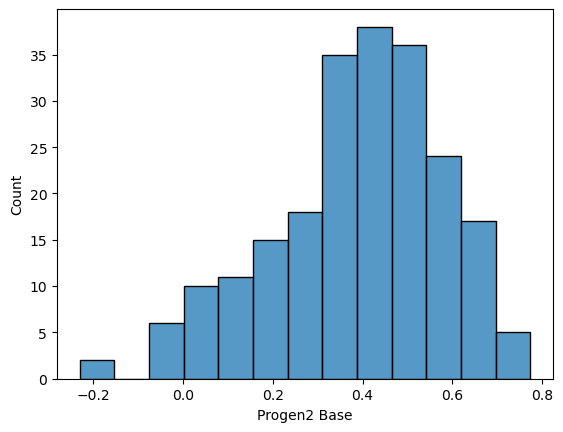

includes_multiple_mutants
False    148
True      69
Name: count, dtype: int64


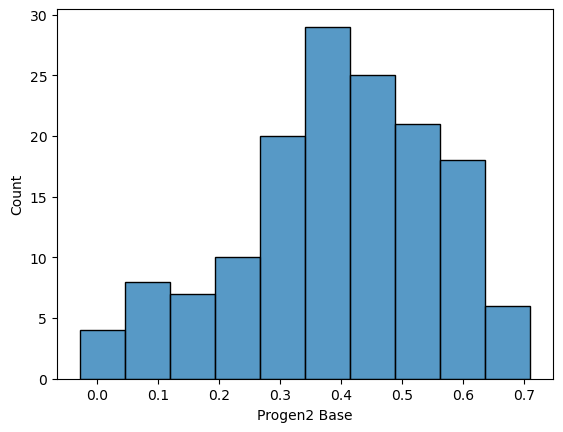

In [30]:
# Check distribution of scores
sns.histplot(df_spearmans["Progen2 Base"])
plt.show()

print(df_spearmans["includes_multiple_mutants"].value_counts())  # Note: Could also calculate Spearmans manually on just the singles

sns.histplot(df_spearmans[~df_spearmans["includes_multiple_mutants"]]["Progen2 Base"])
plt.show()

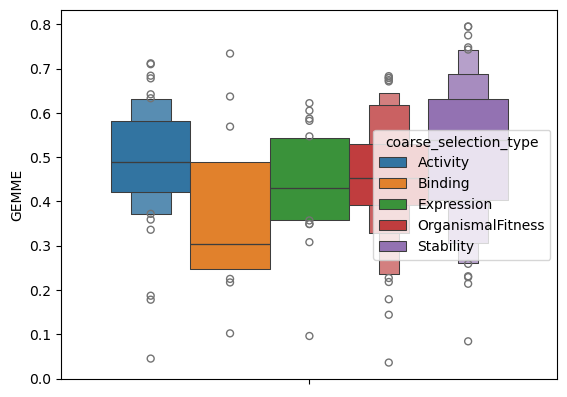

Singles: coarse_selection_type
OrganismalFitness    70
Activity             38
Expression           17
Stability            15
Binding               8
Name: count, dtype: int64


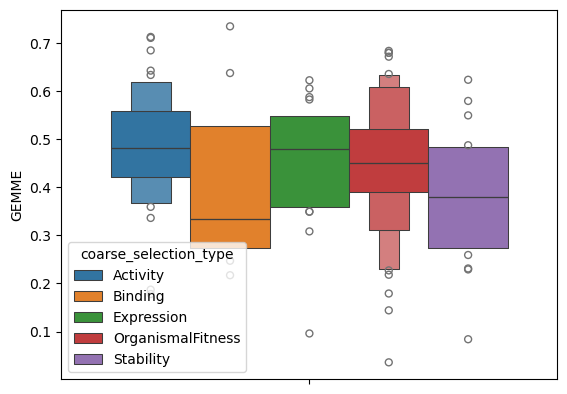

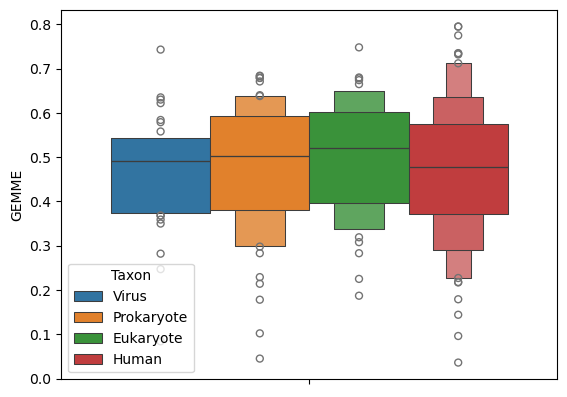

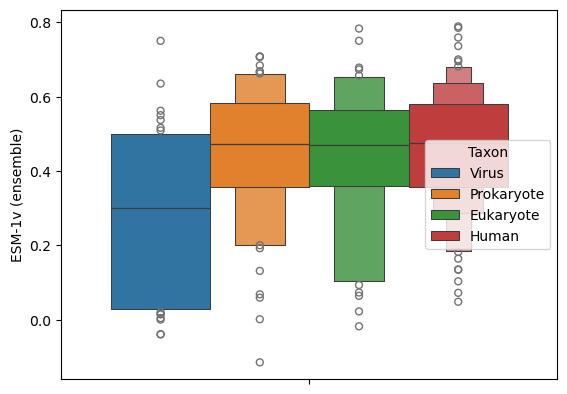

In [64]:
hue_order = sorted(df_spearmans["coarse_selection_type"].unique())
sns.boxenplot(df_spearmans, y="GEMME", hue="coarse_selection_type", hue_order=hue_order)
plt.show()
# Just showing singles: Note: Don't use singles for 
sns.boxenplot(df_spearmans[~df_spearmans["includes_multiple_mutants"]], y="GEMME", hue="coarse_selection_type", hue_order=hue_order)
print(f"Singles: {df_spearmans[~df_spearmans['includes_multiple_mutants']]['coarse_selection_type'].value_counts()}")
plt.show()

sns.boxenplot(df_spearmans, y="GEMME", hue="Taxon")
plt.show()

sns.boxenplot(df_spearmans, y="ESM-1v (ensemble)", hue="Taxon")
plt.show()

## Check alignment statistics

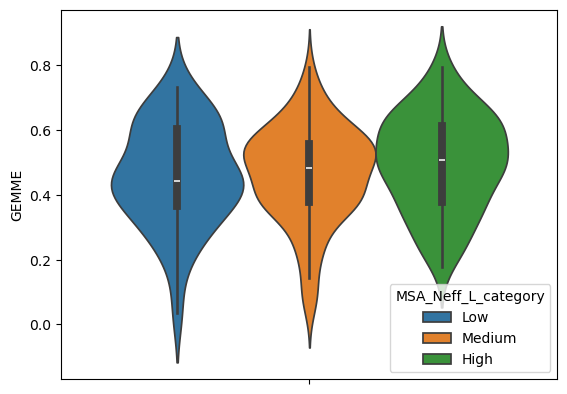

In [50]:
hue_order = ["Low", "Medium", "High"]
sns.violinplot(df_spearmans, y="GEMME", hue="MSA_Neff_L_category", hue_order=hue_order)
plt.show()

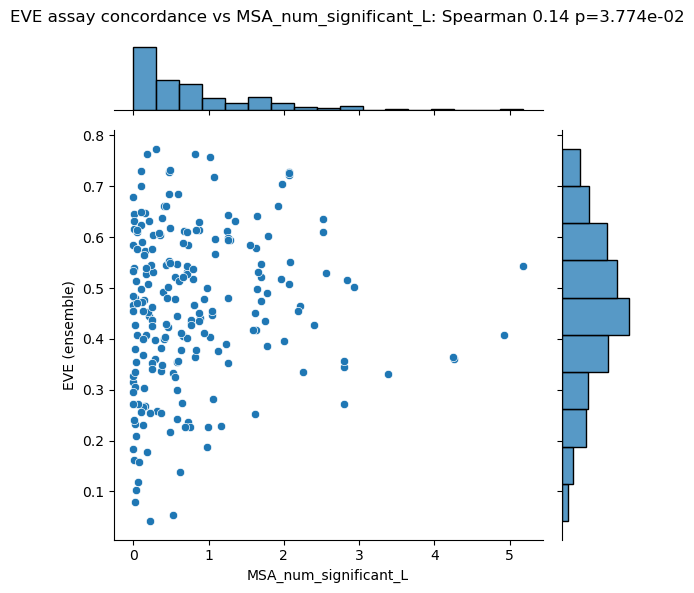

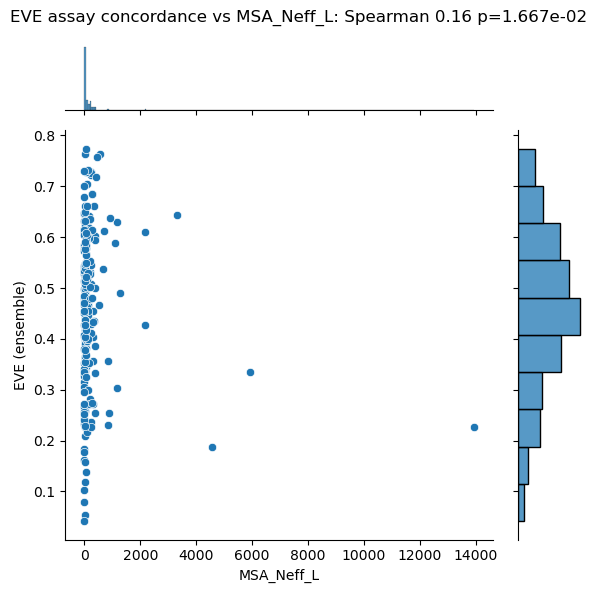

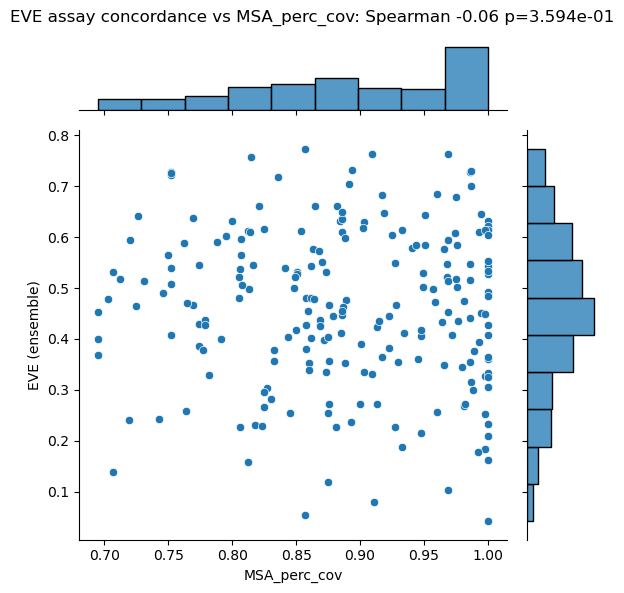

In [60]:
alignment_columns = ["MSA_num_significant_L", "MSA_Neff_L", "MSA_perc_cov"]
for col in alignment_columns:
    sns.jointplot(df_spearmans, x=col, y="EVE (ensemble)")
    s = spearmanr(df_spearmans[col], df_spearmans["EVE (ensemble)"], nan_policy="omit")
    plt.suptitle(f"EVE assay concordance vs {col}: Spearman {s[0]:.2f} p={s[1]:.3e}")
    plt.tight_layout()
    plt.show()

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon,DMS_binarization_cutoff,DMS_binarization_method,DMS_filename,DMS_id,DMS_number_multiple_mutants,DMS_number_single_mutants,DMS_total_number_mutants,MSA_N_eff,MSA_Neff_L,MSA_bitscore,MSA_end,MSA_filename,MSA_len,MSA_num_cov,MSA_num_seqs,MSA_num_significant,MSA_num_significant_L,MSA_perc_cov,MSA_start,MSA_theta,ProteinGym_version,UniProt_ID,coarse_selection_type,first_author,includes_multiple_mutants,jo,molecule_name,pdb_file,pdb_range,raw_DMS_directionality,raw_DMS_filename,raw_DMS_mutant_column,raw_DMS_phenotype_name,raw_mut_offset,region_mutated,selection_assay,selection_type,seq_len,source_organism,target_seq,taxon,title,weight_file_name,year,MSA_N_eff_log,MSA_N_eff_L_log
213,VRPI_BPT7_Tsuboyama_2023_2WNM,-0.119,0.043,0.164,0.194,0.078,0.119,0.082,0.147,0.213,0.233,0.498,0.368,0.374,0.252,0.410,0.507,0.587,0.612,0.468,0.128,-0.020,0.135,0.133,0.222,0.215,0.202,0.131,0.199,0.291,0.084,0.499,0.429,0.242,0.065,0.059,0.122,-0.039,-0.028,-0.057,0.064,0.083,0.006,0.254,0.056,0.501,0.357,0.589,0.557,0.593,0.606,1047,Stability,VRPI_BPT7,Medium,Virus,-1.100000,manual,VRPI_BPT7_Tsuboyama_2023_2WNM.csv,VRPI_BPT7_Tsuboyama_2023_2WNM,0,1047,1047,1555.8,31.751020,0.2,56,VRPI_BPT7_2023-08-07_b02.a2m,56,49.0,6266,3.0,0.061224,0.875,1,0.01,1.0,VRPI_BPT7,Stability,Tsuboyama,False,10.1038/s41586-023-06328-67,Bacterial RNA polymerase inhibitor,VRPI_BPT7.pdb,1-56,1,Tsuboyama2023_Dataset2_Dataset64,mut_type,ddG_ML_float,NaN,1-56,Stability,cDNA display proteolysis,56,Escherichia phage,SLSVDNKKFWATVESSEHSFEVPIYAETLDEALELAEWQYVPAGFE...,Virus,Mega-scale experimental analysis of protein fo...,VRPI_BPT7_theta0.01_2023-08-07_b02.npy,2023,7.349745,3.457925
159,RFAH_ECOLI_Tsuboyama_2023_2LCL,0.064,0.210,0.212,0.233,0.230,0.227,-0.015,0.238,0.250,0.237,0.248,0.175,0.200,-0.032,0.078,0.055,0.299,0.261,0.246,0.249,-0.067,0.059,0.121,0.115,-0.043,0.130,0.151,0.114,0.158,0.214,0.268,0.213,-0.009,0.009,0.102,0.133,0.107,0.144,0.156,0.220,0.216,0.208,0.115,-0.075,0.193,0.107,0.304,0.248,0.384,0.328,1326,Stability,RFAH_ECOLI,High,Prokaryote,-0.401406,median,RFAH_ECOLI_Tsuboyama_2023_2LCL.csv,RFAH_ECOLI_Tsuboyama_2023_2LCL,357,969,1326,11748.4,230.360784,0.4,55,RFAH_ECOLI_2023-08-07_b04.a2m,55,51.0,86049,35.0,0.686275,0.927,1,0.20,1.0,RFAH_ECOLI,Stability,Tsuboyama,True,10.1038/s41586-023-06328-45,Transcription antitermination protein RfaH,RFAH_ECOLI.pdb,1-55,1,Tsuboyama2023_Dataset2_Dataset42,mut_type,ddG_ML_float,NaN,1-55,Stability,cDNA display proteolysis,55,Escherichia coli,ATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHS...,Prokaryote,Mega-scale experimental analysis of protein fo...,RFAH_ECOLI_theta0.2_2023-08-07_b04.npy,2023,9.371472,5.439647
113,OTU7A_HUMAN_Tsuboyama_2023_2L2D,0.116,0.243,0.184,0.201,0.224,0.227,0.192,0.134,0.167,0.236,0.434,0.604,0.581,0.205,0.563,0.588,0.319,0.362,0.408,0.155,0.184,0.178,0.221,0.275,0.345,0.260,0.380,0.307,0.148,0.259,0.406,0.388,0.132,0.168,0.225,0.349,0.201,0.198,0.308,0.242,0.220,0.262,0.365,0.184,0.543,0.548,0.532,0.533,0.610,0.537,635,Stability,OTU7A_HUMAN,High,Human,-1.000000,manual,OTU7A_HUMAN_Tsuboyama_2023_2L2D.csv,OTU7A_HUMAN_Tsuboyama_2023_2L2D,0,635,635,514715.2,13911.221620,0.2,42,OTU7A_HUMAN_2023-08-07_b02.a2m,42,37.0,1359071,28.0,0.756757,0.881,1,0.20,1.0,OTU7A_HUMAN,Stability,Tsuboyama,False,10.1038

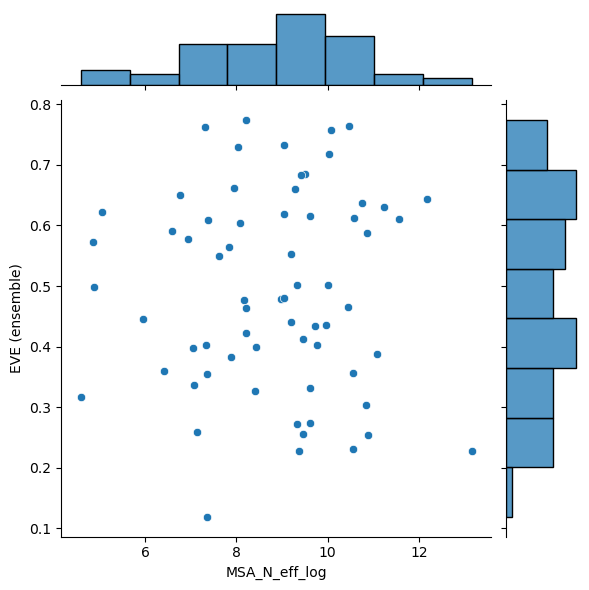

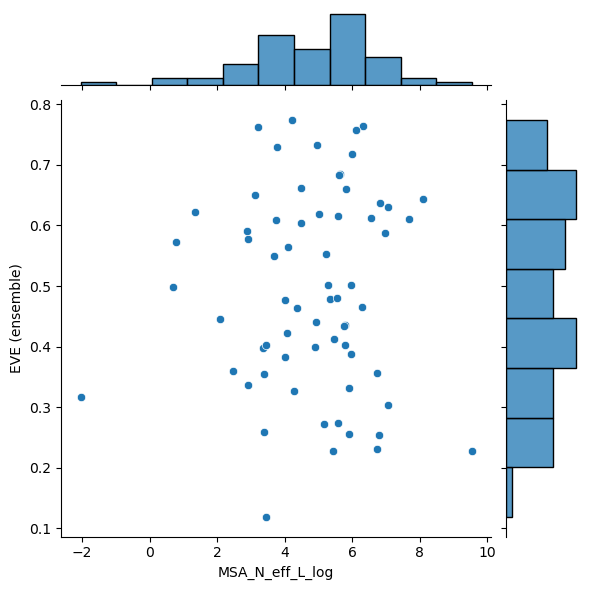

In [45]:
# Just stability
tmp = df_spearmans[df_spearmans["coarse_selection_type"] == "Stability"].copy()
tmp["MSA_N_eff_log"] = np.log(tmp["MSA_N_eff"])
tmp["MSA_N_eff_L_log"] = np.log(tmp["MSA_Neff_L"])
sns.jointplot(data=tmp, x="MSA_N_eff_log", y="EVE (ensemble)")
sns.jointplot(data=tmp, x="MSA_N_eff_L_log", y="EVE (ensemble)")
tmp.sort_values(by="EVE (ensemble)")

## ProGen

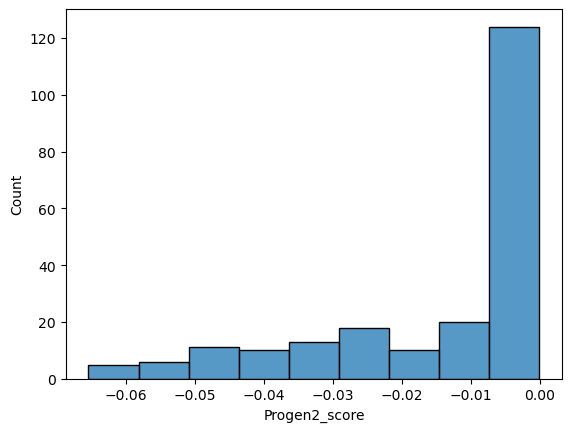

In [6]:
progen_scores_out = pd.read_csv("./model_scores_out/progen2-base/all_wt.csv")
sns.histplot(progen_scores_out["Progen2_score"])
plt.show()

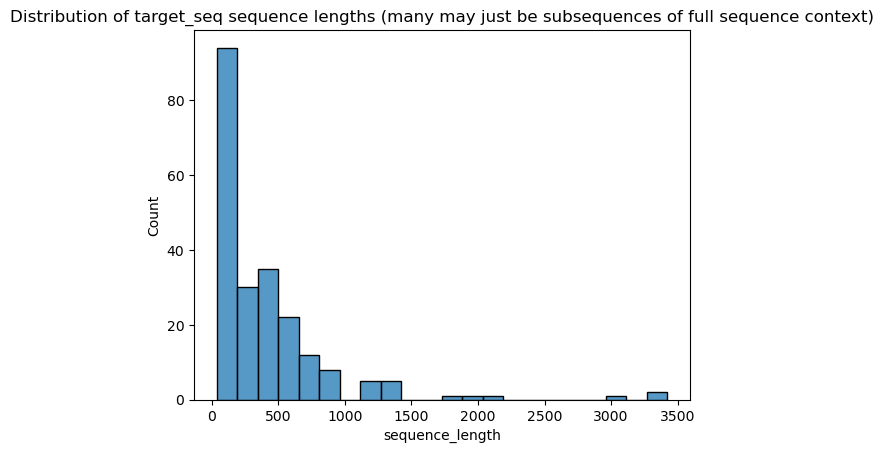

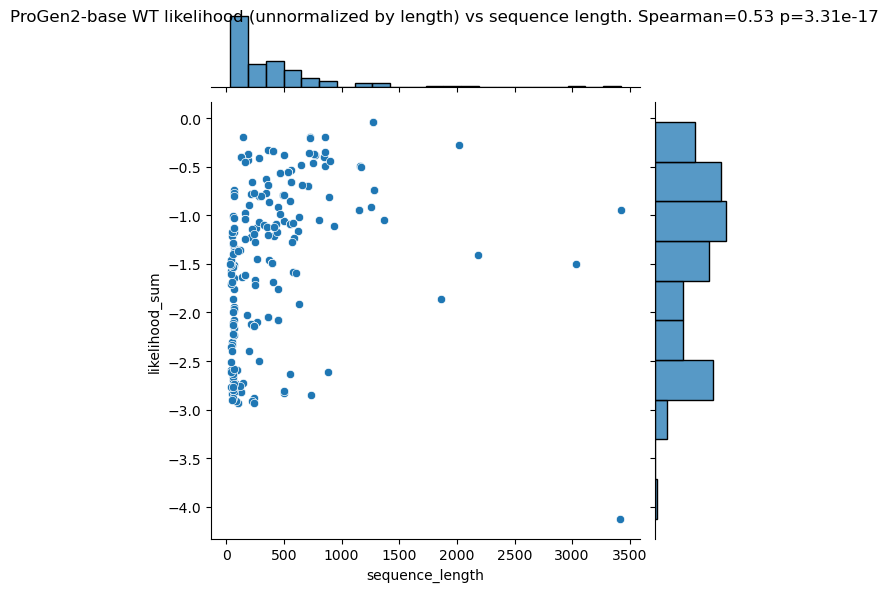

Proportion of sequences starting with M: M_start
True     147
False     70
Name: count, dtype: int64
Which assays have non-M start? first_author
Tsuboyama      60
Vanella         2
Yee             2
Kennouche       1
Ghose           1
Estevam         1
Chen            1
Suphatrakul     1
Flynn           1
Name: count, dtype: int64


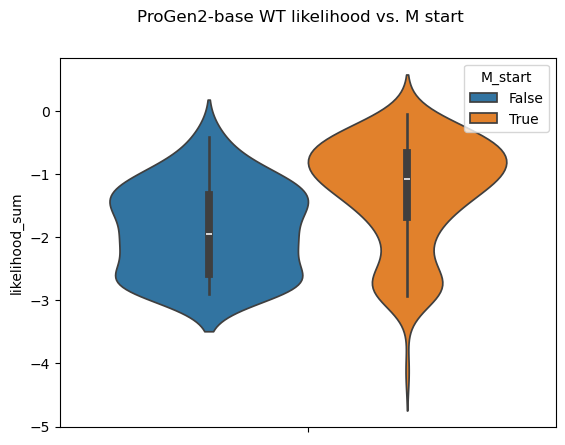

In [120]:
# Likelihood (sum)
progen_scores_out["sequence_length"] = progen_scores_out["mutated_sequence"].str.len()
progen_scores_out["M_start"] = progen_scores_out["mutated_sequence"].str.startswith("M")
progen_scores_out["likelihood_sum"] = progen_scores_out["Progen2_score"] * progen_scores_out["mutated_sequence"].str.len()
progen_scores_out["likelihood_mean"] = progen_scores_out["Progen2_score"]
progen_scores_out["perplexity"] = np.exp(-progen_scores_out["likelihood_mean"])

sns.histplot(progen_scores_out["sequence_length"])
plt.title("Distribution of target_seq sequence lengths (many may just be subsequences of full sequence context)")
plt.show()

# How do likelihoods change with length?
s = spearmanr(progen_scores_out["sequence_length"], progen_scores_out["likelihood_sum"])
sns.jointplot(x=progen_scores_out["sequence_length"], y=progen_scores_out["likelihood_sum"])
plt.suptitle(f"ProGen2-base WT likelihood (unnormalized by length) vs sequence length. Spearman={s[0]:.2f} p={s[1]:.2e}")
plt.show()



# How do likelihoods change with M start vs not?
tmp = progen_scores_out.copy()
print("Proportion of sequences starting with M:", tmp["M_start"].value_counts())
print("Which assays have non-M start?", df_ref[~df_ref["target_seq"].str.startswith("M")]["first_author"].value_counts())
sns.violinplot(y=tmp["likelihood_sum"], hue=tmp["M_start"])
plt.suptitle("ProGen2-base WT likelihood vs. M start")
plt.show()

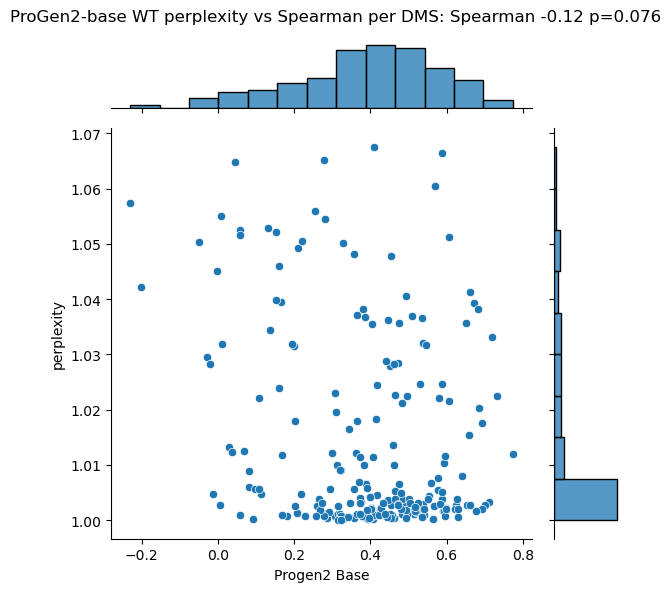

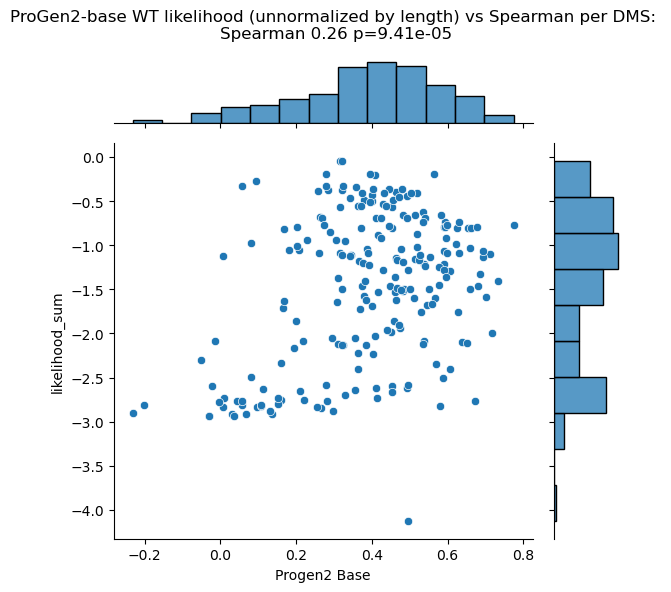

In [121]:
# Checking correlations between WT perplexity and Spearman
sns.jointplot(x=df_spearmans["Progen2 Base"], y=progen_scores_out["perplexity"])
s = spearmanr(df_spearmans["Progen2 Base"], progen_scores_out["perplexity"])
plt.suptitle(f"ProGen2-base WT perplexity vs Spearman per DMS: Spearman {s[0]:.2f} p={s[1]:.3f}")
plt.tight_layout()
plt.show()

sns.jointplot(x=df_spearmans["Progen2 Base"], y=progen_scores_out["likelihood_sum"])
s = spearmanr(df_spearmans["Progen2 Base"], progen_scores_out["likelihood_sum"])
plt.suptitle(f"ProGen2-base WT likelihood (unnormalized by length) vs Spearman per DMS: \nSpearman {s[0]:.2f} p={s[1]:.2e}")
plt.tight_layout()
plt.show()

# Let's take just e.g. the stability assays because they're high-signal
# Could also calculate the relative score compared to top model (might get close to correcting for noise, but kind of removes the point for non-natural proteins)
# NOTE: Should we rather include the likelihood of the stop token to get the true sequence probability?

In [122]:
# Check the ProGen scores are similar for the same target_seq
progen_dedup = progen_scores_out.drop_duplicates()
progen_dedup

,mutated_sequence,Progen2_score,sequence_length,likelihood_sum,likelihood_mean,perplexity,M_start
0,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.000277,3423,-0.948026,-0.000277,1.000277,True
1,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,-0.000466,852,-0.396826,-0.000466,1.000466,True
2,FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...,-0.006060,161,-0.975615,-0.006060,1.006078,False
3,MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...,-0.031423,87,-2.733815,-0.031423,1.031922,True
4,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,-0.001173,565,-0.662576,-0.001173,1.001173,True
...,...,...,...,...,...,...,...
211,MGSTWGSPGWVRLALCLTGLVLSLYALHVKAARARDRDYRALCDVG...,-0.009919,163,-1.616721,-0.009919,1.009968,True
213,SLSVDNKKFWATVESSEHSFEVPIYAETLDEALELAEWQYVPAGFE...,-0.051474,56,-2.882522,-0.051474,1.052821,False
214,PREAYIVTIEKGKPGQTVTWYQLRADHPKPDSLISEHPTAQEAMDA...,-0.055737,52,-2.898310,-0.055737,1.057319,False
215,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,-0.000756,504,-0.380909,-0.000756,1.000756,True


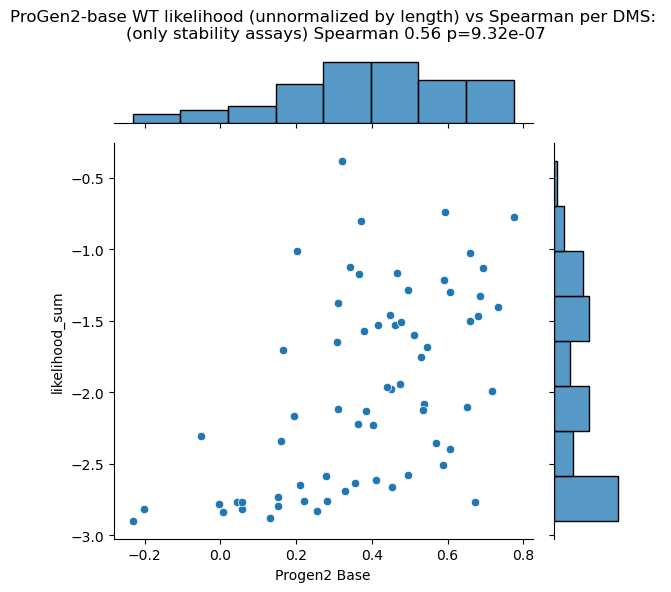

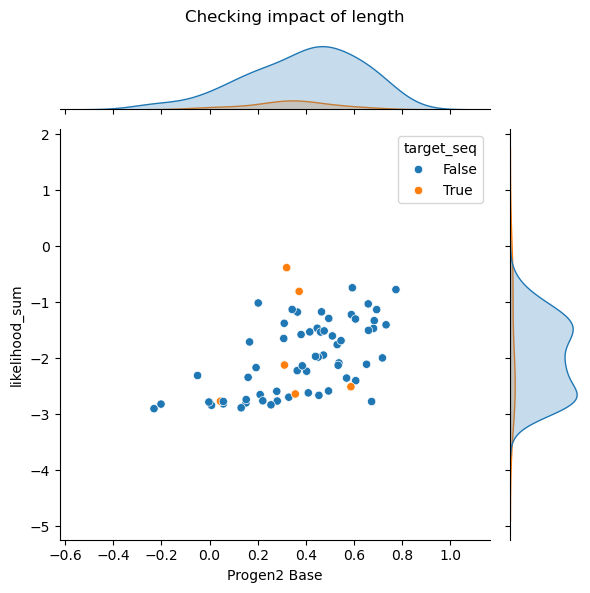

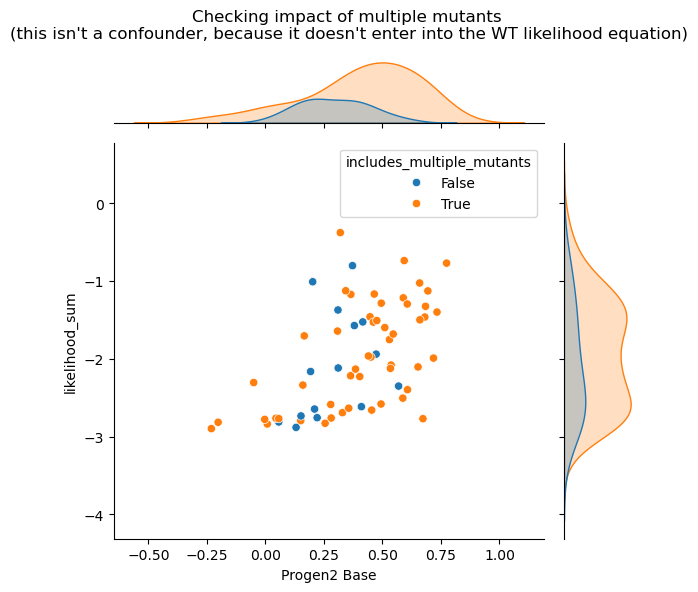

In [123]:
scores_merged_progen = pd.merge(df_spearmans, progen_dedup, left_on="target_seq", right_on="mutated_sequence")
stability_subset = scores_merged_progen[scores_merged_progen["coarse_selection_type"] == "Stability"].copy()
s = spearmanr(stability_subset["Progen2 Base"], stability_subset["likelihood_sum"])
sns.jointplot(x=stability_subset["Progen2 Base"], y=stability_subset["likelihood_sum"])
plt.suptitle(f"ProGen2-base WT likelihood (unnormalized by length) vs Spearman per DMS: \n(only stability assays) Spearman {s[0]:.2f} p={s[1]:.2e}")
plt.tight_layout()
plt.show()


sns.jointplot(x=stability_subset["Progen2 Base"], y=stability_subset["likelihood_sum"], hue=stability_subset["target_seq"].str.startswith("M"))#stability_subset["sequence_length"])
plt.suptitle("Checking impact of length")
plt.tight_layout()
plt.show()

sns.jointplot(x=stability_subset["Progen2 Base"], y=stability_subset["likelihood_sum"], hue=stability_subset["includes_multiple_mutants"])
plt.suptitle("Checking impact of multiple mutants \n(this isn't a confounder, because it doesn't enter into the WT likelihood equation)")
plt.tight_layout()
plt.show()

## Tmp sequence length ProGen

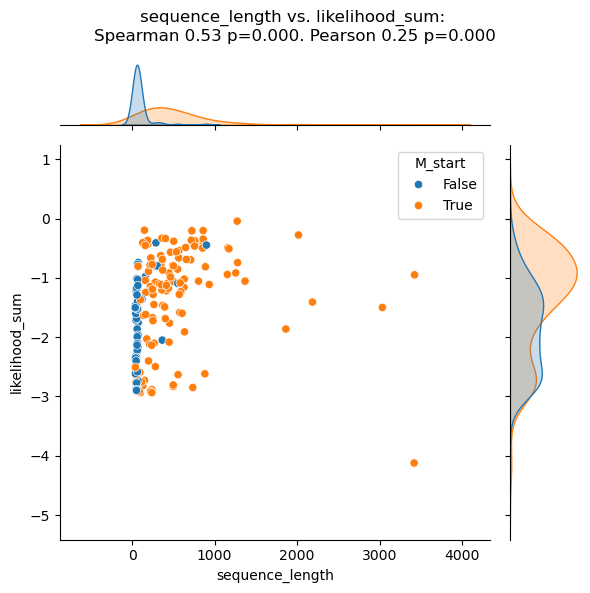

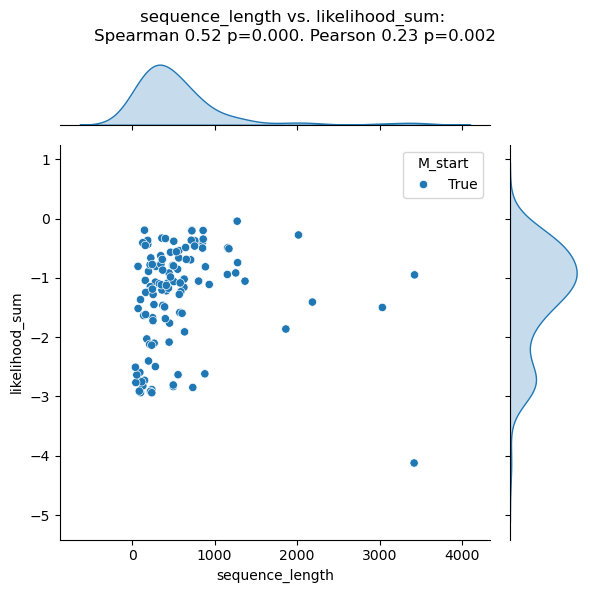

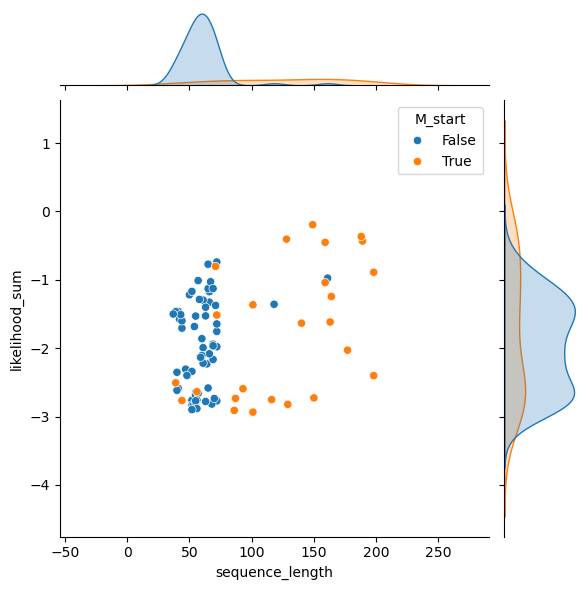

In [180]:
assay_spearman, wt_likelihood = "sequence_length", "likelihood_sum"
sns.jointplot(x=assay_spearman, y=wt_likelihood, data=progen_dedup, hue="M_start")  # We can see a strong linear correlation between M_start and likelihood (see bar plots above)
s = spearmanr(scores_merged_progen[assay_spearman], scores_merged_progen[wt_likelihood], nan_policy="omit")
from scipy.stats import pearsonr
# scores_merged_progen = scores_merged_progen.dropna(subset=[assay_spearman, wt_likelihood])
x = scores_merged_progen[assay_spearman]
y = scores_merged_progen[wt_likelihood]
r = pearsonr(x, y)
plt.suptitle(f"{assay_spearman} vs. {wt_likelihood}: \nSpearman {s[0]:.2f} p={s[1]:.3f}. Pearson {r[0]:.2f} p={r[1]:.3f}")
plt.tight_layout()
plt.show()

# Relationship stays even when just looking at sequences starting with M
assay_spearman, wt_likelihood = "sequence_length", "likelihood_sum"
sns.jointplot(x=assay_spearman, y=wt_likelihood, data=progen_dedup[progen_dedup["M_start"]], hue="M_start")  # We can see a strong linear correlation between M_start and likelihood (see bar plots above)
s = spearmanr(progen_dedup[assay_spearman], progen_dedup[wt_likelihood], nan_policy="omit")
from scipy.stats import pearsonr
# scores_merged_progen = scores_merged_progen.dropna(subset=[assay_spearman, wt_likelihood])
x = progen_dedup[assay_spearman]
y = progen_dedup[wt_likelihood]
r = pearsonr(x, y)
plt.suptitle(f"{assay_spearman} vs. {wt_likelihood}: \nSpearman {s[0]:.2f} p={s[1]:.3f}. Pearson {r[0]:.2f} p={r[1]:.3f}")
plt.tight_layout()
plt.show()

sns.jointplot(x=assay_spearman, y=wt_likelihood, data=progen_dedup[progen_dedup["sequence_length"] < 200], hue="M_start")  # We can see a strong linear correlation
plt.show()

# Much higher range in likelihoods wrt sequence length than with ESM, for the small ones for example
# Note: Why is this 3500 sequence length one such low likelihood??

In [129]:
# What are the longest proteins?
scores_merged_progen.sort_values(by="sequence_length", ascending=False).head(10)

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon,DMS_binarization_cutoff,DMS_binarization_method,DMS_filename,DMS_id,DMS_number_multiple_mutants,DMS_number_single_mutants,DMS_total_number_mutants,MSA_N_eff,MSA_Neff_L,MSA_bitscore,MSA_end,MSA_filename,MSA_len,MSA_num_cov,MSA_num_seqs,MSA_num_significant,MSA_num_significant_L,MSA_perc_cov,MSA_start,MSA_theta,ProteinGym_version,UniProt_ID,coarse_selection_type,first_author,includes_multiple_mutants,jo,molecule_name,pdb_file,pdb_range,raw_DMS_directionality,raw_DMS_filename,raw_DMS_mutant_column,raw_DMS_phenotype_name,raw_mut_offset,region_mutated,selection_assay,selection_type,seq_len,source_organism,target_seq,taxon,title,weight_file_name,year,mutated_sequence,Progen2_score,sequence_length,likelihood_sum,likelihood_mean,perplexity,M_start
0,A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.475,0.454,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375,0.216,0.361,0.309,0.317,0.305,0.329,0.342,0.328,0.312,0.293,0.430,0.319,0.296,0.005,0.304,0.331,0.272,0.362,0.366,0.351,0.361,0.358,0.373,-0.060,-0.073,0.131,-0.061,-0.061,0.131,0.287,0.129,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus,0.043249,median,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV_Sourisseau_2019,0,9576,9576,1357.9,2.732193,0.2,804,A0A140D2T1_ZIKV_theta0.99_281-804_11-26-2021_b...,524,497.0,16501,329.0,0.661972,0.948,281,0.01,0.1,A0A140D2T1_ZIKV,OrganismalFitness,Sourisseau,False,10.1128/JVI.01291-19,Zika virus env,A0A140D2T1_ZIKV.pdb,291-794,1,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,mutant,effect,NaN,291-794,Viral replication,Growth,3423,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,Virus,Deep Mutational Scanning Comprehensively Maps ...,A0A140D2T1_ZIKV_theta_0.01.npy,2019,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-0.000277,3423,-0.948026,-0.000277,1.000277,True
25,BRCA2_HUMAN_Erwood_2022_HEK293T,0.481,0.346,0.440,0.445,0.447,0.481,0.095,0.477,-0.023,-0.082,0.480,0.183,0.103,0.088,0.103,0.416,0.510,0.464,0.473,0.033,0.090,0.494,0.534,0.482,0.533,0.483,0.496,0.499,0.014,0.400,0.297,0.328,0.140,0.119,0.185,0.138,0.420,0.425,0.426,0.419,0.415,0.414,0.163,0.093,0.497,0.047,0.047,0.497,-0.091,0.285,265,OrganismalFitness,BRCA2_HUMAN,NaN,Human,0.800000,manual,BRCA2_HUMAN_Erwood_2022_HEK293T.csv,BRCA2_HUMAN_Erwood_2022_HEK293T,0,265,265,NaN,NaN,0.1,3418,BRCA2_HUMAN_2023-10-12_b01.a2m,3418,NaN,933,NaN,NaN,NaN,1,0.20,1.0,BRCA2_HUMAN,OrganismalFitness,Erwood,False,10.1038/s41587-021-01201-1,BRCA2,BRCA2_HUMAN_1-1000.pdb|BRCA2_HUMAN_1001-2085.p...,1-1000|1001-2085|2086-2832,1,41587_2021_1201_MOESM3_ESM.xlsx,Protein Annotation,Function Score,NaN,388-2654,Fitness,Growth,3418,Homo sapiens,MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEP...,Human,Saturation variant interpretation using CRISPR...,BRCA2_HUMAN_theta0.2_2023-10-12_b01.npy,2022,MPIGSKERPTFFEIFKTRCNKADLGPISLNWFEELSSEAPPYNSEP...,-0.001206,3418,-4.122126,-0.001206,1.001207,True
130,POLG_HCVJF_Qi_2014,0.605,0.547,0.410,0.413,0.605,0.614,-0.039,0.196,0.608,0.591,0.178,0.637,0.635,0.101,0.128,0.114,0.116,0.090,0.078,0.260,0.400,0.443,0.452,0.492,0.422,0.475,0.320,0.410,0.517,0.630,0.587,0.485,0.182,0.474,0.505,0.522,0.515,0.547,0.578,0.480,0.528,0.560,0.114,0.053,0.506,0.109,0.109,0.506,0.643,0.350,1630,OrganismalFitness,POLG_HCVJF,Medium,Vi

## ESM2

In [140]:
df_esm_wt_pseudoppl_old = df_esm_wt_pseudoppl.copy()

In [143]:
df_esm_wt_pseudoppl = pd.read_csv("./model_scores_out/esm1v_t33_650M_UR90S_1_wt_pseudo_ppl/all_wt.csv")
df_esm_wt_pseudoppl = df_esm_wt_pseudoppl.drop(columns=[c for c in df_esm_wt_pseudoppl.columns if "Ensembl" in c or "DMS_score" in c])
df_esm_wt_pseudoppl = df_esm_wt_pseudoppl.rename(columns={"esm1v_t33_650M_UR90S_1":"ESM1v_wt_pseudo_ppl"})
df_esm_wt_pseudoppl

,mutated_sequence,ESM1v_wt_pseudo_ppl
0,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,-12941.488922
1,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,-7479.261695
2,FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...,-1550.662315
3,MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...,-354.171648
4,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,-5073.500586
...,...,...
182,MGSTWGSPGWVRLALCLTGLVLSLYALHVKAARARDRDYRALCDVG...,-1218.057225
183,SLSVDNKKFWATVESSEHSFEVPIYAETLDEALELAEWQYVPAGFE...,-226.470604
184,PREAYIVTIEKGKPGQTVTWYQLRADHPKPDSLISEHPTAQEAMDA...,-220.723548
185,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...,-4214.837010


In [167]:
df_tmp = pd.read_csv("./model_scores_out/esm2_t30_150M_UR50D/all_wt.csv")
df_tmp2 = pd.read_csv("./model_scores_out/esm1v_t33_650M_UR90S_1/all_wt.csv")
df_esm = df_tmp.merge(df_tmp2.drop(columns=["DMS_id"]), on="mutated_sequence").merge(df_esm_wt_pseudoppl, on="mutated_sequence")
df_esm = df_esm.rename(columns={"esm2_t30_150M_UR50D": "ESM2_small_pseudo_ppl", "esm1v_t33_650M_UR90S_1": "ESM1v_pseudo_ppl"})
df_esm["sequence_length"] = df_esm["mutated_sequence"].str.len()
# Provide length normalized scores too
df_esm["ESM1v_pseudo_ppl_normalized"] = df_esm["ESM1v_pseudo_ppl"] / df_esm["sequence_length"]
df_esm["ESM2_small_pseudo_ppl_normalized"] = df_esm["ESM2_small_pseudo_ppl"] / df_esm["sequence_length"]
# df_esm["ESM1v_wt_pseudo_ppl_normalized"] = df_esm["ESM1v_wt_pseudo_ppl"] / df_esm["sequence_length"]
df_esm["ESM1v_wt_pseudo_ppl_normalized"] = (df_esm["ESM1v_wt_pseudo_ppl"] - 55.45538881) / (-7.66193143 * df_esm["sequence_length"])

scores_merged_esm = pd.merge(df_spearmans, df_esm.drop(columns="DMS_id"), left_on="target_seq", right_on="mutated_sequence")
scores_merged_esm

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),MSA Transformer (ensemble),ESM-1b,ESM-1v (single),ESM-1v (ensemble),ESM2 (8M),ESM2 (35M),ESM2 (150M),ESM2 (650M),ESM2 (3B),ESM2 (15B),Wavenet,RITA S,RITA M,RITA L,RITA XL,Progen2 S,Progen2 M,Progen2 Base,Progen2 L,Progen2 XL,GEMME,VESPA,VESPAl,ProtGPT2,Tranception S no retrieval,Tranception M no retrieval,Tranception L no retrieval,Tranception S,Tranception M,Tranception L,TranceptEVE S,TranceptEVE M,TranceptEVE L,CARP (38M),CARP (600K),CARP (640M),CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon,DMS_binarization_cutoff,DMS_binarization_method,DMS_filename,DMS_id,DMS_number_multiple_mutants,DMS_number_single_mutants,DMS_total_number_mutants,MSA_N_eff,MSA_Neff_L,MSA_bitscore,MSA_end,MSA_filename,MSA_len,MSA_num_cov,MSA_num_seqs,MSA_num_significant,MSA_num_significant_L,MSA_perc_cov,MSA_start,MSA_theta,ProteinGym_version,UniProt_ID,coarse_selection_type,first_author,includes_multiple_mutants,jo,molecule_name,pdb_file,pdb_range,raw_DMS_directionality,raw_DMS_filename,raw_DMS_mutant_column,raw_DMS_phenotype_name,raw_mut_offset,region_mutated,selection_assay,selection_type,seq_len,source_organism,target_seq,taxon,title,weight_file_name,year,mutated_sequence,ESM2_small_pseudo_ppl,ESM1v_pseudo_ppl,ESM1v_wt_pseudo_ppl,sequence_length,ESM1v_pseudo_ppl_normalized,ESM2_small_pseudo_ppl_normalized,ESM1v_wt_pseudo_ppl_normalized
0,A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.475,0.454,-0.001,-0.048,0.015,-0.073,-0.054,-0.058,0.213,0.363,0.375,0.216,0.361,0.309,0.317,0.305,0.329,0.342,0.328,0.312,0.293,0.430,0.319,0.296,0.005,0.304,0.331,0.272,0.362,0.366,0.351,0.361,0.358,0.373,-0.060,-0.073,0.131,-0.061,-0.061,0.131,0.287,0.129,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus,0.043249,median,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV_Sourisseau_2019,0,9576,9576,1357.9,2.732193,0.2,804,A0A140D2T1_ZIKV_theta0.99_281-804_11-26-2021_b...,524,497.0,16501,329.0,0.661972,0.948,281,0.01,0.1,A0A140D2T1_ZIKV,OrganismalFitness,Sourisseau,False,10.1128/JVI.01291-19,Zika virus env,A0A140D2T1_ZIKV.pdb,291-794,1,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,mutant,effect,NaN,291-794,Viral replication,Growth,3423,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,Virus,Deep Mutational Scanning Comprehensively Maps ...,A0A140D2T1_ZIKV_theta_0.01.npy,2019,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,NaN,NaN,-12941.488922,3423,NaN,NaN,0.495560
1,A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.514,0.514,0.456,0.492,0.516,-0.003,0.015,0.035,0.080,0.132,0.164,0.465,0.496,0.507,0.509,0.505,0.497,0.501,0.463,0.490,0.484,0.496,0.541,0.507,0.327,0.492,0.483,0.514,0.509,0.503,0.513,0.524,0.518,0.528,0.422,-0.021,0.497,0.429,0.329,0.451,0.206,0.136,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus,-2.200000,manual,A0A192B1T2_9HIV1_Haddox_2018.csv,A0A192B1T2_9HIV1_Haddox_2018,0,12577,12577,36319.9,43.237976,0.9,852,A0A192B1T2_9HIV1_theta0.99_full_11-26-2021_b09...,852,840.0,74854,2382.0,2.835714,0.986,1,0.01,0.1,A0A192B1T2_9HIV1,OrganismalFitness,Haddox,False,10.7554/eLife.34420,HIV env (BF520),A0A192B1T2_9HIV1.pdb,1-852,1,A0A192B1T2_9HIV1_Haddox_2018.csv,mutant,fitness,NaN,30-691,Viral replication,Growth,852,HIV,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,Virus,Mapping mutational effects along the evolution...,A0A192B1T2_9HIV1_theta_0.01.npy,2018,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,-2528.751885,-5660.529293,-7479.261695,852,-6.643814,-2.968019,1.154221
2,A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.094,0.102,0.040,0.068,0.068,-0.037,-0.047,-0.016,0.030,0.027,0.025,0.067,-0.010,0.047,0.071,0.088,0.050,0.088,0.080,0.089,0.095,0.045,0.046,0.036,0.030,0.036,0.055,0.099,0.031,0.041,0.057,0.058,0.061,0

## Checking impact of sequence length on ESM: Yes there's a strong linear correlation, we should divide by sequence length

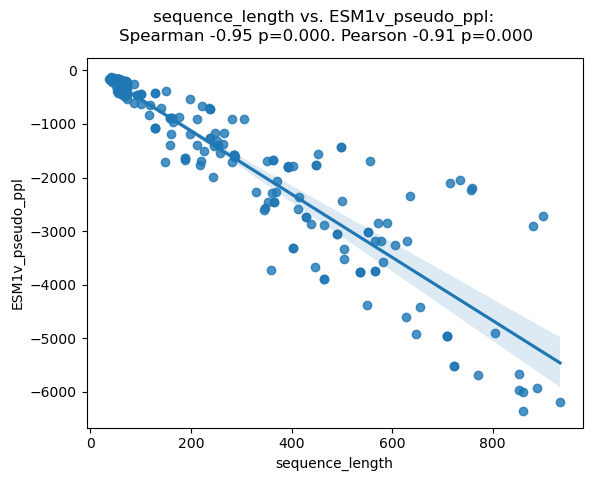

[[-5.90035279]] [50.41680048]


In [168]:
assay_spearman, wt_likelihood = "sequence_length", "ESM1v_pseudo_ppl"
sns.regplot(x=assay_spearman, y=wt_likelihood, data=scores_merged_esm)  # We can see a strong linear correlation
s = spearmanr(scores_merged_esm[assay_spearman], scores_merged_esm[wt_likelihood], nan_policy="omit")
from scipy.stats import pearsonr
scores_merged_esm_dropna = scores_merged_esm.dropna(subset=[assay_spearman, wt_likelihood])
x = scores_merged_esm_dropna[assay_spearman]
y = scores_merged_esm_dropna[wt_likelihood]
r = pearsonr(x, y)
plt.suptitle(f"{assay_spearman} vs. {wt_likelihood}: \nSpearman {s[0]:.2f} p={s[1]:.3f}. Pearson {r[0]:.2f} p={r[1]:.3f}")
plt.show()

# Get slope of this fit:
# import statsmodels as sm
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
print(lr.coef_, lr.intercept_)  # The slope seems to be around -6, and offset is 8.5 residues (50/6)

## Check differences between ESM1v and ESM1v wt pseudo ppl

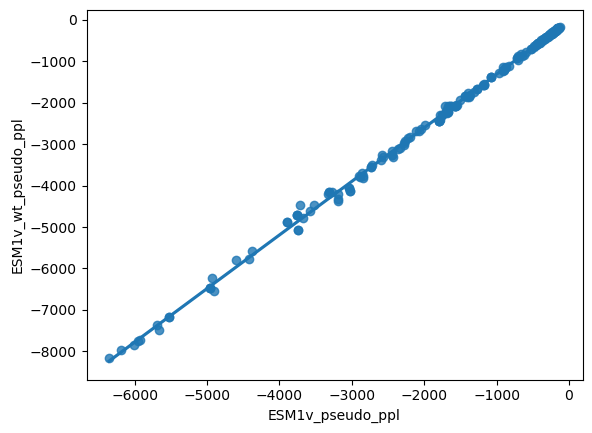

[[1.29309019]] [-19.02218178]


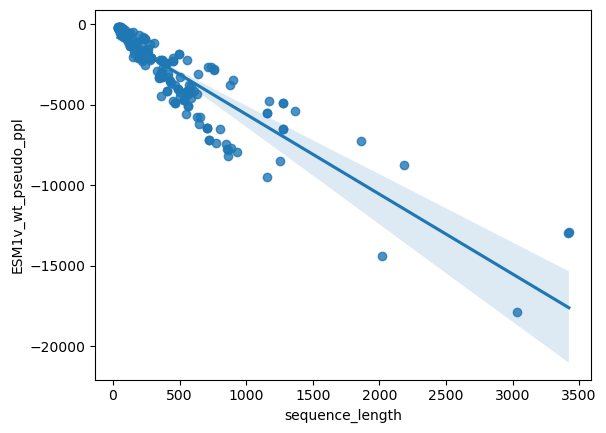

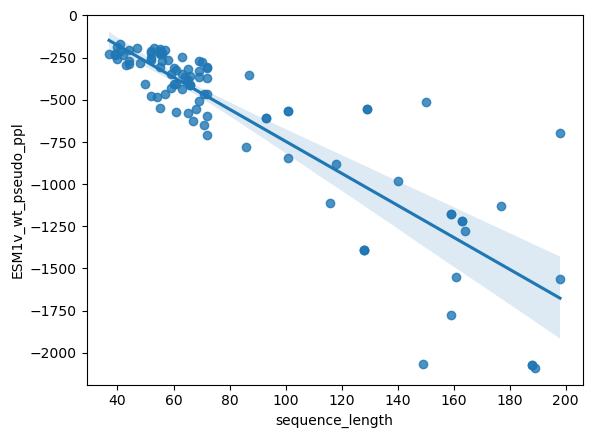

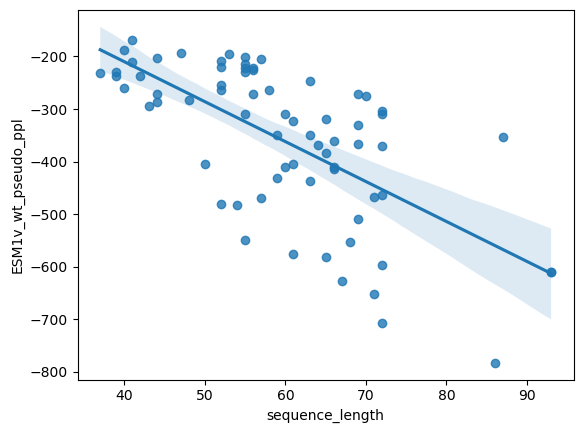

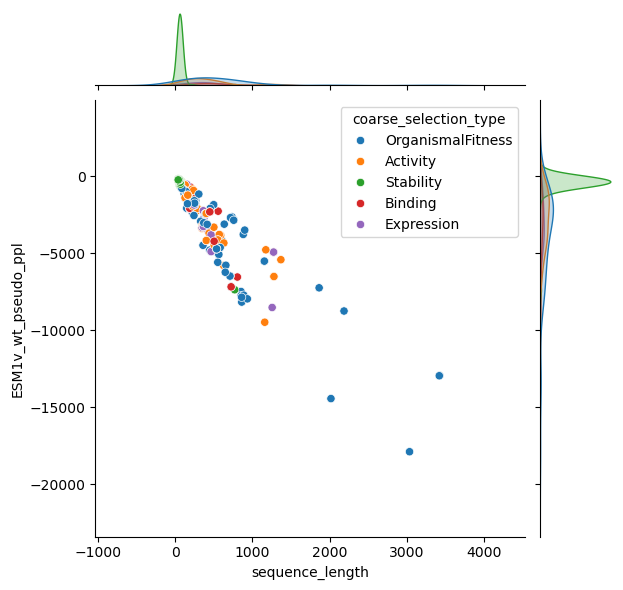

[[-7.66193143]] [55.45538881]


In [173]:
# The WT marginals are 1.2x bigger (larger negative number -> lower probability?)
sns.regplot(data=scores_merged_esm, x="ESM1v_pseudo_ppl", y="ESM1v_wt_pseudo_ppl")
plt.show()

scores_merged_esm_dropna = scores_merged_esm.dropna(subset=["ESM1v_pseudo_ppl", "ESM1v_wt_pseudo_ppl"])
x = scores_merged_esm_dropna["ESM1v_pseudo_ppl"]
y = scores_merged_esm_dropna["ESM1v_wt_pseudo_ppl"]
lr = LinearRegression()
lr.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
print(lr.coef_, lr.intercept_)

sns.regplot(data=scores_merged_esm, x="sequence_length", y="ESM1v_wt_pseudo_ppl")
plt.show()

sns.regplot(data=scores_merged_esm[scores_merged_esm["sequence_length"] < 200], x="sequence_length", y="ESM1v_wt_pseudo_ppl")
plt.show()

sns.regplot(data=scores_merged_esm[scores_merged_esm["sequence_length"] < 100], x="sequence_length", y="ESM1v_wt_pseudo_ppl")
plt.show()

sns.jointplot(data=scores_merged_esm, x="sequence_length", y="ESM1v_wt_pseudo_ppl", hue="coarse_selection_type")
plt.show()

x = scores_merged_esm_dropna["sequence_length"]
y = scores_merged_esm_dropna["ESM1v_wt_pseudo_ppl"]
lr = LinearRegression()
lr.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
print(lr.coef_, lr.intercept_)  # Effectively 1 residue intercept between WT and masked-marginal-pseudoppl? Coincidence that it's "20" lower?


In [170]:
# WT-pseudo-ppl vs sequence length: -7.66 relationship, and offset of 55 (so 7.23 residues of sequence length)

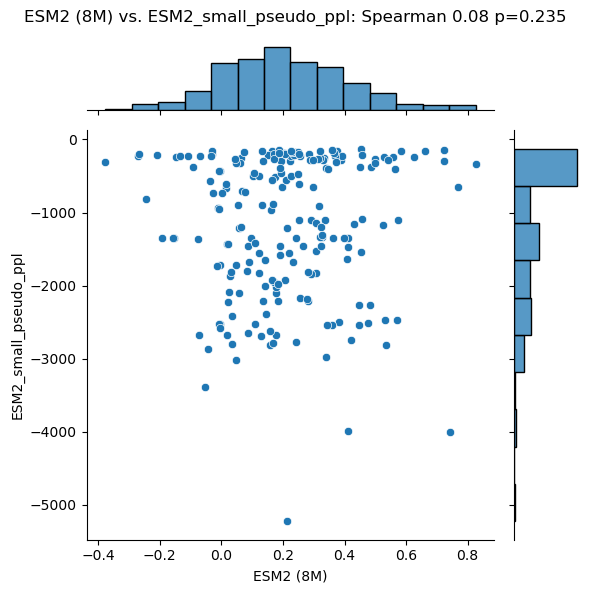

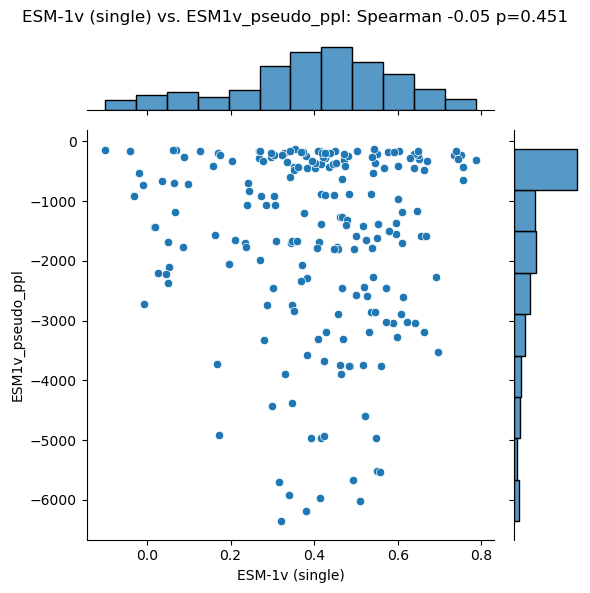

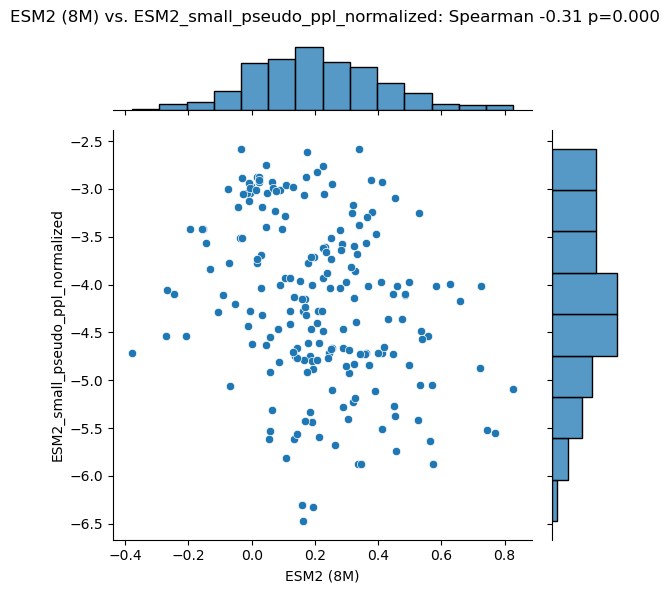

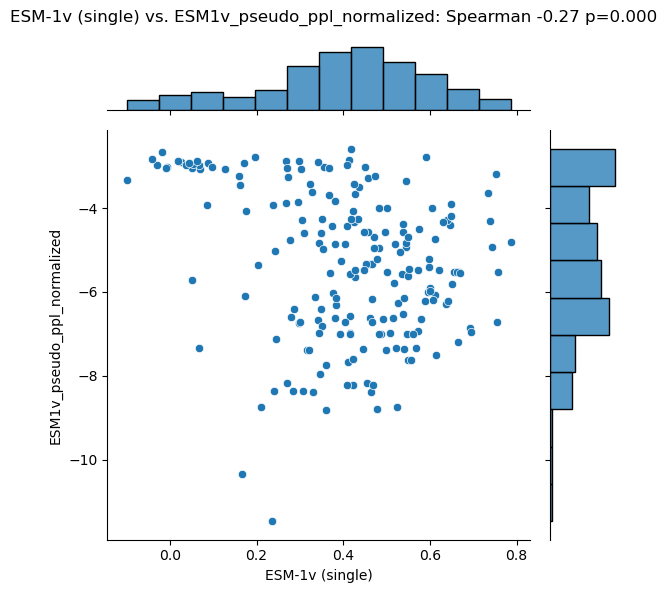

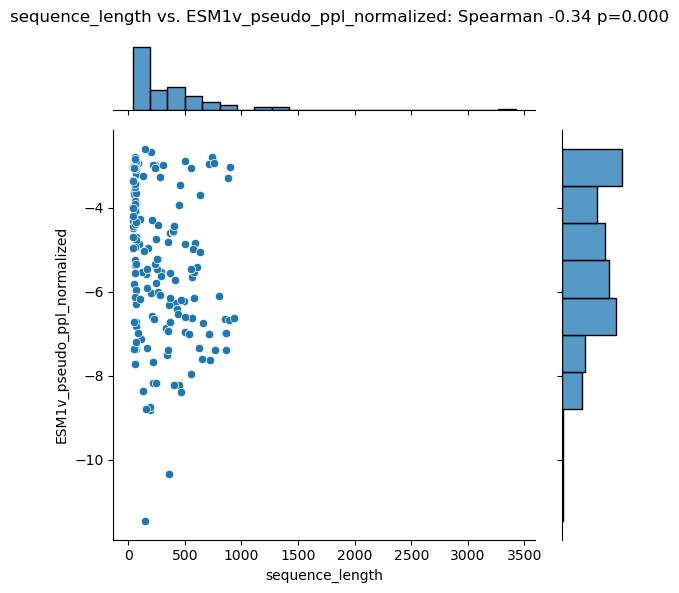

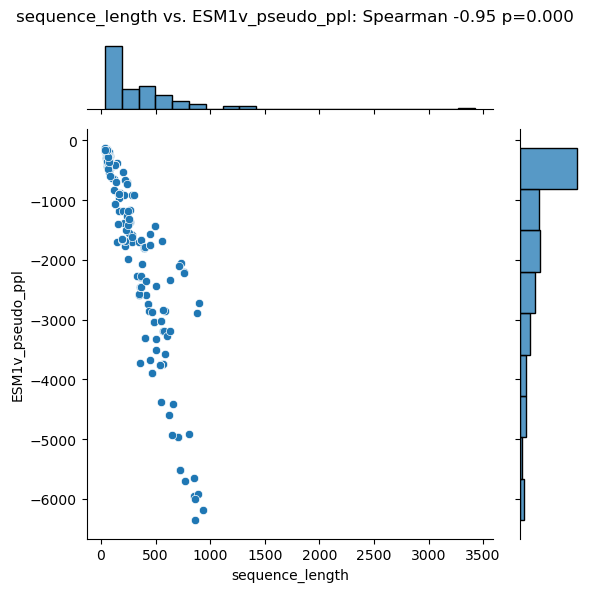

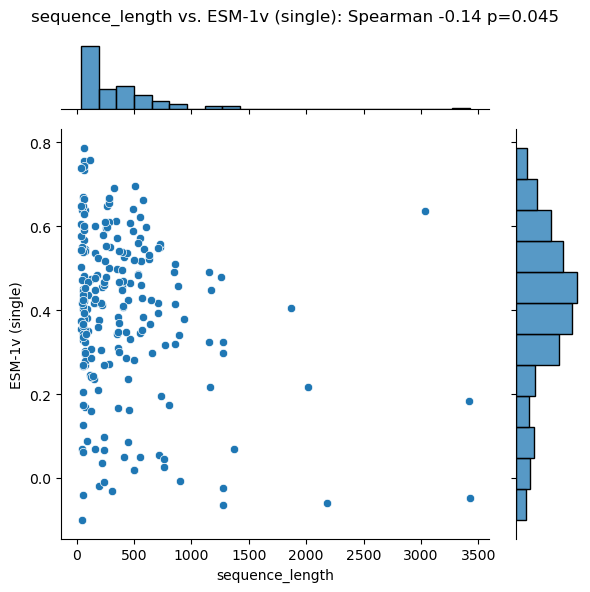

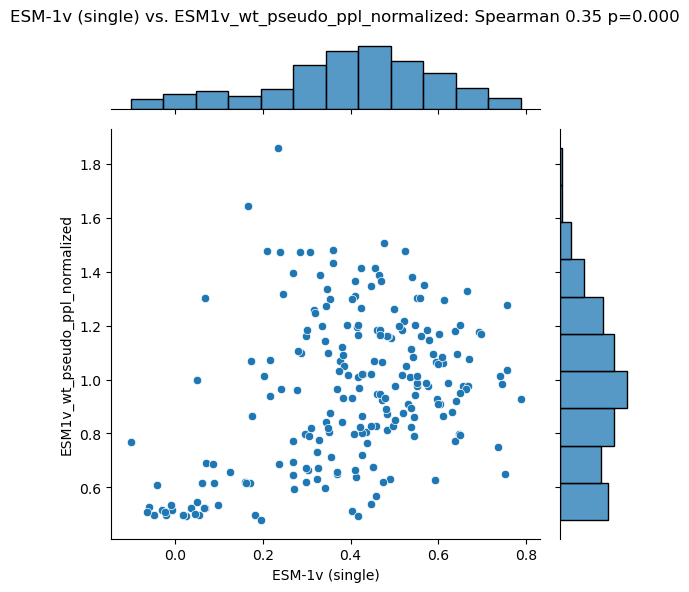

In [171]:
col_tuples = [("ESM2 (8M)", "ESM2_small_pseudo_ppl"), 
              ("ESM-1v (single)", "ESM1v_pseudo_ppl"), 
              ("ESM2 (8M)", "ESM2_small_pseudo_ppl_normalized"),
              ("ESM-1v (single)", "ESM1v_pseudo_ppl_normalized"),
              ("sequence_length", "ESM1v_pseudo_ppl_normalized"),
              ("sequence_length", "ESM1v_pseudo_ppl"),
              ("sequence_length", "ESM-1v (single)"),
              ("ESM-1v (single)", "ESM1v_wt_pseudo_ppl_normalized"),]
for assay_spearman, wt_likelihood in col_tuples:
    sns.jointplot(x=assay_spearman, y=wt_likelihood, data=scores_merged_esm)
    s = spearmanr(scores_merged_esm[assay_spearman], scores_merged_esm[wt_likelihood], nan_policy="omit")
    plt.suptitle(f"{assay_spearman} vs. {wt_likelihood}: Spearman {s[0]:.2f} p={s[1]:.3f}")
    plt.tight_layout()
    plt.show()

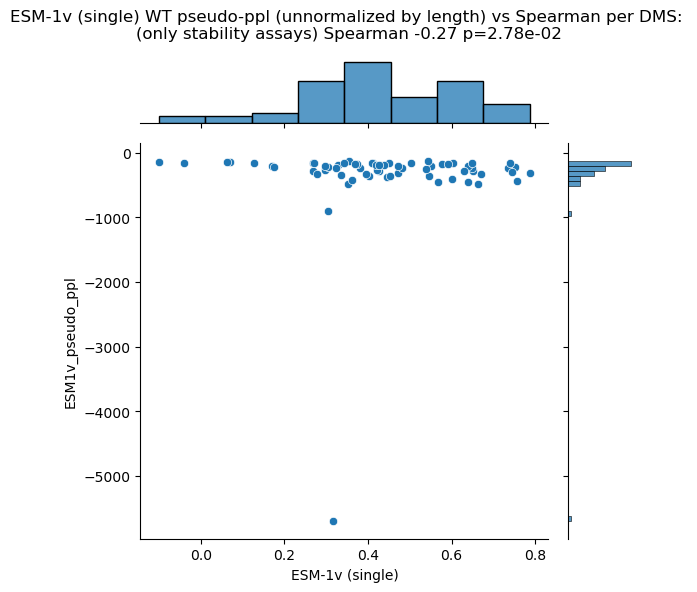

In [154]:
# Check correlation of ESM2_small and ESM1v
stability_subset = scores_merged_esm[scores_merged_esm["coarse_selection_type"] == "Stability"].copy()
s = spearmanr(stability_subset["ESM-1v (single)"], stability_subset["ESM1v_pseudo_ppl"])
sns.jointplot(data=stability_subset, x="ESM-1v (single)", y="ESM1v_pseudo_ppl")
plt.suptitle(f"ESM-1v (single) WT pseudo-ppl (unnormalized by length) vs Spearman per DMS: \n(only stability assays) Spearman {s[0]:.2f} p={s[1]:.2e}")
plt.tight_layout()
plt.show()  # TODO check that outlier